In [1]:
from matplotlib import pyplot as plt
from seaborn import lineplot
import pandas as pd
from modules.data_types import Transmission
from modules.utils import get_frequency_linspace
from scipy.fftpack import rfft, irfft
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
from ipywidgets import interact
from bokeh.plotting import figure as bfigure
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import gridplot
from bokeh.models import Range1d
from typing import *

In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
t = Transmission.from_hdf5('./data/hier_clustering_all_promoters.ptrn')

In [4]:
normalize = lambda a: (a - np.min(a)) / (np.max(a - np.min(a)))

In [5]:
def interpolate(cutoff: int, raw_curve: np.ndarray, rfft_curve: Optional[np.ndarray] = None) -> np.ndarray:
    """
    Normalize and interpolate IFT so it's of the same length as the raw curve.
    
    :param cutoff: frequency domain cut-off for computing the irfft
    :param raw_curve: raw curve which was the input for rfft. 1D array
    :param rfft_curve: rfft of raw_curve
    
    :return: normalized interpolated IFT
    """
    x = np.arange(0, raw_curve.size)
    
    if rfft_curve is None:
        rfft_curve = rfft(raw_curve)
    
    ift = irfft(rfft_curve[:cutoff])
    
    xp = np.linspace(0, raw_curve.size, cutoff)
    interp = np.interp(x, xp, fp=ift)
    
    return normalize(interp)

In [6]:
def sosd(u: np.ndarray, v: np.ndarray) -> float:
    """
    Sum of squared differences between u and v
    
    :param u: 1D array
    :param v: 1D array
    
    :return: sum of squared differences between u and v
    """
    
    r = u - v
    return np.dot(r, r)

In [7]:
def step_sosd(curve: np.ndarray) -> np.ndarray:
    """
    Calculate the sum of squared differences between a raw time series and 
    its interpolated IFT with stepwise increments in frequency domains that
    are included for computing the IFT.
    
    :param curve: raw time series
    
    :return: 1D array where (index + 1) of each element is the frequency
             domain cutoff for the SOSD of that element
    """
    ft = rfft(curve)
    
    r = np.zeros(shape=(curve.size - 1), dtype=np.float64)
    
    for step in range(1, curve.size):
        interp_ift = interpolate(step, curve, ft)
        r[step - 1] = sosd(curve, interp_ift)
    
    return r

In [8]:
ndata = np.vstack(t.df._NORMALIZE.values)

a = ndata[0]
b = interpolate(1000, a)

f1 = bfigure(plot_width=1000, plot_height=200, y_range=(-0.1, 1.1))
g1 = f1.line(np.arange(a.size), a)

f2 = bfigure(plot_width=1000, plot_height=200, x_range=f1.x_range, y_range=f1.y_range)
g2 = f2.line(np.arange(b.size), b)

In [9]:
def plot_comparison(curve_ix: int, cutoff: int):
    curve = ndata[curve_ix]
    ift_interp = interpolate(cutoff, curve)
    
    g1.data_source.data['y'] = curve
    g2.data_source.data['y'] = ift_interp
    
    f1.y_range = Range1d(-0.1, 1.1)
    f2.y_range = Range1d(-0.1, 1.1)
    
    print(f"SOSD {sosd(curve, ift_interp)}")
    
    push_notebook()

In [10]:
p = gridplot([[f1], [f2]])
show(p, notebook_handle=True)
interact(plot_comparison, curve_ix = (0, ndata.shape[0] - 1), cutoff = (1, ndata.shape[1] - 1, 10))

interactive(children=(IntSlider(value=128, description='curve_ix', max=257), IntSlider(value=1491, description…

<function __main__.plot_comparison(curve_ix:int, cutoff:int)>

In [11]:
with Pool(7) as p:
    rs = list(
              tqdm(
                  p.imap(step_sosd, ndata),
                        total=ndata.shape[0]
                  )
            )

  0%|          | 0/258 [00:00<?, ?it/s]/home/kushal/python-virtual-environments/mesmerize/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/kushal/python-virtual-environments/mesmerize/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/kushal/python-virtual-environments/mesmerize/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/kushal/python-virtual-environments/mesmerize/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/kushal/python-virtual-environments/mesmerize/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarnin

In [12]:
rs = np.vstack(rs)

/home/kushal/python-virtual-environments/mesmerize/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


[None, None, None, None]

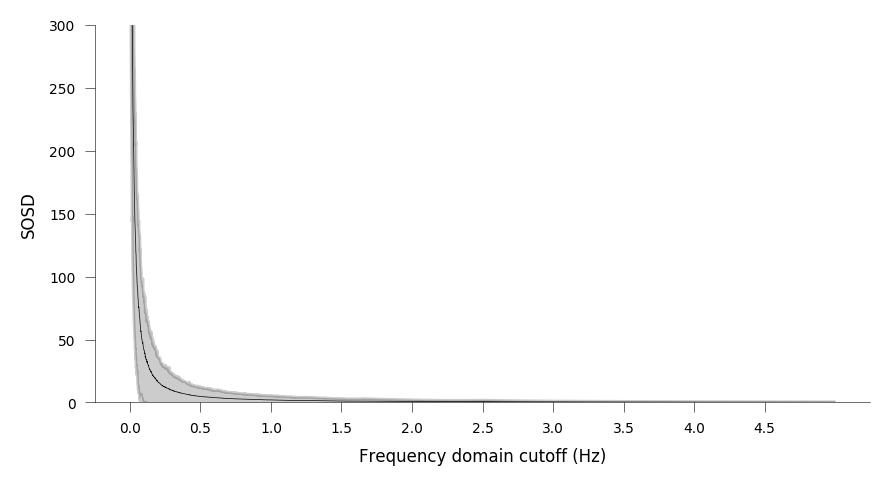

In [13]:
fig = plt.figure(figsize=(5, 2.5), dpi=200)
ax = plt.subplot(111)

lineplot(data=pd.DataFrame(rs).melt(), x='variable', y='value', 
         c='k', ci='sd', linewidth=0.25, ax=ax)

ax.set_ylim(0, 300)

ax.set_xlabel("Frequency domain cutoff (Hz)", fontdict={'fontsize': 6})
ax.set_ylabel("SOSD", fontdict={'fontsize': 6})

freqs, nf = get_frequency_linspace(t)
num_freqs = t.df._RFFT.values[0].size
max_freq = freqs[num_freqs - 1]
interval = 0.5 # This is in Hertz

ax.set_xticks(np.arange(0, num_freqs, (num_freqs * interval) / max_freq))
ax.set_xticklabels(np.arange(0, max_freq, interval))

ax.tick_params(axis='both', which='major', labelsize=5, width=.2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.setp(ax.spines.values(), linewidth=0.2)

In [14]:
fig.savefig('./figs/sosd_freqs.png', dpi=1200, bbox_inches='tight', pad_inches=0)